<a href="https://colab.research.google.com/github/saiffardin/pytorch/blob/main/hand-written-digit-recognition/bangla_handwritten_digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Sep 11 11:03:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/MyDrive/Colab Notebooks/SC_asmnt_2'

/content/gdrive/MyDrive/Colab Notebooks/SC_asmnt_2


In [ ]:
!ls

# Imports

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# Hyper Parameters

In [5]:
# Hyperparameters
num_hidden_nodes = 350 
iteration = 20000

learning_rate = 0.02
batch_size = 128

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# toukir
'''
num_hidden_nodes = 250 
iteration = 10000 # it supposed to be 20000

learning_rate = 0.01
batch_size = 85

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
'''

In [ ]:
# moontaha
'''
num_hidden_nodes = 220 
iteration = 20000 # it supposed to be 20000

learning_rate = 0.001
batch_size = 122

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
'''

In [ ]:
# raju
'''
num_hidden_nodes = 330 
iteration = 10000 # it supposed to be 20000

learning_rate = 0.028
batch_size = 250

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
'''

# Dataset

## Load CSV

In [6]:
data_labels = pd.read_csv('Dataset_A/training-a.csv', usecols = ['filename', 'digit'])
data_labels

,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0
...,...,...
19697,a19697.png,4
19698,a19698.png,3
19699,a19699.png,8
19700,a19700.png,3


In [ ]:
data_labels.iloc[3, 0]

'a00003.png'

## Custom Dataset

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, img_labels, img_dir, transform=None):
        self.img_labels = img_labels
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        '''returns the number of samples in our dataset'''
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

The `__getitem__` function loads and returns a sample from the dataset at the given index `idx`.

Based on the index, it identifies the image’s location on disk, converts that to a tensor using `read_image`, retrieves the corresponding label from the csv data in `self.img_labels`, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.

In [8]:
img_path = 'Dataset_A/training-a'
mean = [0.5,]
std = [0.5, ]

img_transform = transforms.Compose([
    transforms.ToPILImage(), # to make '__getitem__' work properly
    transforms.Grayscale(num_output_channels=1), # converts 3 channel ds into 1 channel                               
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])



custom_dataset  = CustomImageDataset(img_labels=data_labels, 
                                    img_dir=img_path, 
                                    transform=img_transform)

In [ ]:
# len(custom_dataset)
custom_dataset.__len__()

19702

### plot img

torch.Size([1, 28, 28])
label: 7


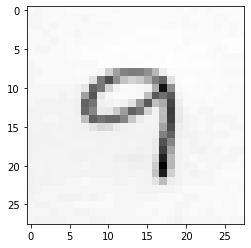

In [ ]:
img,label = custom_dataset.__getitem__(3)

print(img.shape)
print('label:',label)
plt.imshow(img.reshape(28,28), cmap='gray')

## Split Dataset

In [9]:
test_size = 0.2
ds_size = len(custom_dataset)

indices = list(range(ds_size))
np.random.shuffle(indices)

test_split = int(np.floor(test_size * ds_size))
test_indices = indices[:test_split]
train_indices  = indices[test_split:]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [ ]:
test_split

3940

In [ ]:
print(train_sampler)
print(test_sampler)

## Data Loader

In [10]:
train_loader = DataLoader(custom_dataset, 
                          batch_size, 
                          sampler=train_sampler)


test_loader = DataLoader(custom_dataset, 
                         batch_size, 
                         sampler=test_sampler)


small_test_loader = DataLoader(custom_dataset, 
                         10, 
                         sampler=test_sampler)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([128, 1, 28, 28])


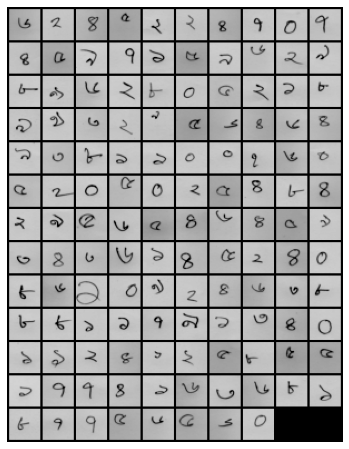

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=10).permute((1, 2, 0)))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([128, 1, 28, 28])


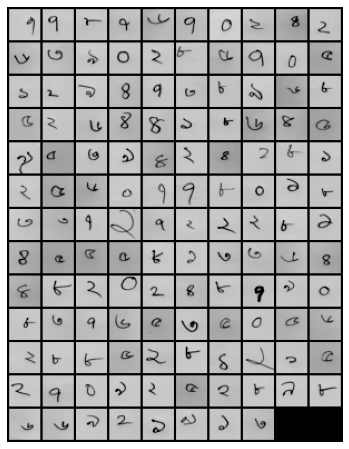

In [ ]:
for images, _ in test_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=10).permute((1, 2, 0)))
    break

# Neural Network Model

In [11]:
num_hidden_nodes

350

In [12]:
class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size):
        super().__init__()

        # 1st hidden layer
        self.linear_1 = nn.Linear(input_size, hidden_size)
        self.leakyRelu_1 = nn.LeakyReLU()

        # 2nd hidden layer
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.leakyRelu_2 = nn.LeakyReLU()

        # 3rd hidden layer
        self.linear_3 = nn.Linear(hidden_size, hidden_size)
        self.leakyRelu_3 = nn.LeakyReLU()

        # 4th hidden layer
        self.linear_4 = nn.Linear(hidden_size, hidden_size)
        self.leakyRelu_4 = nn.LeakyReLU()

        # 5th hidden layer
        self.linear_5 = nn.Linear(hidden_size, hidden_size)
        self.leakyRelu_5 = nn.LeakyReLU()

        # 6th hidden layer
        self.linear_6 = nn.Linear(hidden_size, hidden_size)
        self.leakyRelu_6 = nn.LeakyReLU()

        ### Output layer
        self.linear_out = nn.Linear(hidden_size, num_classes)



    def forward(self, xb):
        # Flatten the image tensors
        # xb = xb.view(xb.size(0), -1)

        out_1 = self.linear_1(xb)       # intermediate outputs of hidden layer - 1
        out_a1 = self.leakyRelu_1(out_1)          # output from  activation function - 1

        out_2 = self.linear_2(out_a1)   # intermediate outputs of hidden layer - 2
        out_a2 = self.leakyRelu_2(out_2)          # output from  activation function - 2

        out_3 = self.linear_3(out_a2)   # intermediate outputs of hidden layer - 3
        out_a3 = self.leakyRelu_3(out_3)          # output from  activation function - 3

        out_4 = self.linear_4(out_a3)   # intermediate outputs of hidden layer - 4
        out_a4 = self.leakyRelu_4(out_4)          # output from  activation function - 4

        out_5 = self.linear_5(out_a4)   # intermediate outputs of hidden layer - 5
        out_a5 = self.leakyRelu_5(out_5)          # output from  activation function - 5

        out_6 = self.linear_6(out_a5)   # intermediate outputs of hidden layer - 6
        out_a6 = self.leakyRelu_6(out_6)          # output from  activation function - 6
        
        out = self.linear_out(out_a6)   # output layer 
        
        return out

    

model = NeuralNetworkModel(input_size  = 28*28, 
                           num_classes = 10, 
                           hidden_size = num_hidden_nodes)


model.to(device)

NeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=350, bias=True)
  (leakyRelu_1): LeakyReLU(negative_slope=0.01)
  (linear_2): Linear(in_features=350, out_features=350, bias=True)
  (leakyRelu_2): LeakyReLU(negative_slope=0.01)
  (linear_3): Linear(in_features=350, out_features=350, bias=True)
  (leakyRelu_3): LeakyReLU(negative_slope=0.01)
  (linear_4): Linear(in_features=350, out_features=350, bias=True)
  (leakyRelu_4): LeakyReLU(negative_slope=0.01)
  (linear_5): Linear(in_features=350, out_features=350, bias=True)
  (leakyRelu_5): LeakyReLU(negative_slope=0.01)
  (linear_6): Linear(in_features=350, out_features=350, bias=True)
  (leakyRelu_6): LeakyReLU(negative_slope=0.01)
  (linear_out): Linear(in_features=350, out_features=10, bias=True)
)

# Log Function


In [ ]:
def writeLog (filePath,txt) :
  # Open a file with access mode 'a'
  file_object = open(filePath, 'a')

  # Append 'hello' at the end of file
  file_object.write(txt + "\n")

  # Close the file
  file_object.close()

# Training

In [ ]:
print(batch_size)
print(iteration)

128
20000


In [ ]:
train_len = int(((len(custom_dataset))* 0.8))
print('train_len:',train_len)

num_epochs = (iteration / (train_len / batch_size))
num_epochs = int(num_epochs)

print('num_epochs:',num_epochs)

train_len: 15761
num_epochs: 162


In [ ]:
learning_rate

0.02

## Train a single batch

In [ ]:
len(train_loader)

124

In [ ]:
for one_batch_images, one_batch_labels in train_loader:
    print('images.shape:', one_batch_images.shape)
    # inputs = images.reshape(-1, 784)
    # print('inputs.shape:', inputs.shape)
    print(one_batch_labels)
    break

images.shape: torch.Size([128, 1, 28, 28])
tensor([2, 2, 6, 1, 6, 2, 2, 7, 5, 1, 6, 6, 6, 2, 3, 4, 3, 3, 0, 6, 3, 7, 1, 1,
        5, 2, 7, 0, 3, 4, 6, 7, 3, 5, 7, 9, 1, 9, 2, 7, 9, 3, 0, 9, 0, 6, 6, 7,
        9, 4, 3, 1, 6, 5, 7, 2, 6, 1, 2, 8, 9, 6, 4, 8, 3, 4, 6, 9, 6, 7, 4, 8,
        4, 2, 9, 6, 9, 7, 6, 6, 6, 9, 2, 8, 0, 6, 3, 2, 7, 3, 6, 8, 6, 8, 0, 3,
        3, 4, 1, 4, 3, 9, 6, 4, 7, 9, 7, 0, 6, 3, 6, 7, 1, 2, 1, 9, 9, 6, 2, 3,
        5, 4, 2, 7, 7, 9, 8, 4])


In [ ]:
len(test_loader)

31

In [ ]:
for one_batch_test_images, one_batch_test_labels in test_loader:
    print('images.shape:', one_batch_test_images.shape)
    print(one_batch_test_labels)
    break

images.shape: torch.Size([128, 1, 28, 28])
tensor([9, 5, 9, 2, 4, 9, 3, 7, 4, 3, 7, 7, 6, 8, 0, 3, 8, 2, 1, 5, 8, 9, 2, 5,
        5, 1, 4, 1, 7, 3, 2, 9, 9, 0, 7, 2, 0, 1, 7, 6, 4, 1, 4, 8, 2, 9, 2, 8,
        9, 1, 5, 9, 1, 1, 6, 7, 0, 3, 8, 8, 7, 0, 0, 2, 2, 1, 8, 4, 2, 7, 8, 2,
        3, 9, 5, 2, 1, 9, 3, 9, 3, 3, 8, 2, 6, 0, 9, 5, 7, 9, 2, 4, 0, 4, 7, 3,
        2, 5, 9, 9, 8, 0, 4, 9, 1, 1, 5, 3, 6, 7, 8, 5, 1, 2, 2, 9, 3, 5, 1, 8,
        7, 8, 1, 6, 1, 2, 7, 1])


In [ ]:
# test check
for i,(one_batch_test_images, one_batch_test_labels) in enumerate(test_loader):
    print('batch -',i)
    print('images.shape:', one_batch_test_images.shape)
    print('labels.shape:', one_batch_test_labels.shape)
    break
    

batch - 0
images.shape: torch.Size([128, 1, 28, 28])
labels.shape: torch.Size([128])


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
iter = 0

for iter in range(1001):
    images = one_batch_images.view(-1, 28*28).to(device)
    labels = one_batch_labels.to(device)

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad()

    # Forward pass to get output/logits
    outputs = model(images) 

    # Calculate Loss: softmax --> cross entropy loss
    loss = criterion(outputs, labels)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()

    # iter += 1

    if iter % 100 == 0:
        # Calculate Accuracy         
        correct = 0
        total = 0
            
        test_images = one_batch_test_images.view(-1, 28*28).to(device)

        # Forward pass only to get logits/output
        test_outputs = model(test_images)

        # Get predictions from the maximum value
        _, predicted = torch.max(test_outputs, 1)

        # Total number of labels
        total += labels.size(0)


        # Total correct predictions
        if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.cpu()).sum() 
        else:
            correct += (predicted == labels).sum()

        accuracy = 100 * correct.item() / total

        # Print Loss
        txt = 'Iteration: {} \t Loss: {:0.5f} \t Accuracy: {:0.5f}'.format(iter, loss.item(), accuracy)
        print(txt)

        # save model
        torch.save(model.state_dict(), f"saved_model/exp-2/exp-2_{iter}.pkl")

        # write on log
        writeLog ('saved_model/exp-2/log.txt', txt)
    
    iter += 1

Iteration: 0 	 Loss: 2.26111 	 Accuracy: 19.53125
Iteration: 100 	 Loss: 2.25944 	 Accuracy: 19.53125
Iteration: 200 	 Loss: 2.25781 	 Accuracy: 19.53125
Iteration: 300 	 Loss: 2.25623 	 Accuracy: 19.53125
Iteration: 400 	 Loss: 2.25469 	 Accuracy: 19.53125
Iteration: 500 	 Loss: 2.25318 	 Accuracy: 19.53125
Iteration: 600 	 Loss: 2.25172 	 Accuracy: 19.53125
Iteration: 700 	 Loss: 2.25030 	 Accuracy: 19.53125
Iteration: 800 	 Loss: 2.24891 	 Accuracy: 19.53125
Iteration: 900 	 Loss: 2.24756 	 Accuracy: 19.53125
Iteration: 1000 	 Loss: 2.24625 	 Accuracy: 19.53125


## Full Training

In [ ]:
num_epochs

162

In [ ]:

'''
TRAIN THE MODEL
'''

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
iter = 0

for epoch in range(num_epochs):
    for images, labels in train_loader:

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        if iter % 100 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total


            # Print Loss
            txt = 'Iteration: {} \t Loss: {:0.5f} \t Accuracy: {:0.5f}'.format(iter, loss.item(), accuracy)
            print(txt)

            # save model
            torch.save(model.state_dict(), f"saved_model/exp-2/exp-2_{iter}.pkl")

            # write on log
            writeLog ('saved_model/exp-2/log.txt', txt)

        iter += 1

    print('epoch - ',epoch)

Iteration: 0 	 Loss: 2.29956 	 Accuracy: 10.17766
Iteration: 100 	 Loss: 2.30117 	 Accuracy: 10.17766
epoch -  0
Iteration: 200 	 Loss: 2.30320 	 Accuracy: 10.17766
epoch -  1
Iteration: 300 	 Loss: 2.30236 	 Accuracy: 9.61929
epoch -  2
Iteration: 400 	 Loss: 2.30299 	 Accuracy: 9.61929
epoch -  3
Iteration: 500 	 Loss: 2.30198 	 Accuracy: 9.61929
Iteration: 600 	 Loss: 2.30157 	 Accuracy: 11.44670
epoch -  4
Iteration: 700 	 Loss: 2.30212 	 Accuracy: 9.34010
epoch -  5
Iteration: 800 	 Loss: 2.30159 	 Accuracy: 9.61929
epoch -  6
Iteration: 900 	 Loss: 2.30198 	 Accuracy: 9.34010
epoch -  7
Iteration: 1000 	 Loss: 2.30101 	 Accuracy: 9.34010
Iteration: 1100 	 Loss: 2.30240 	 Accuracy: 9.34010
epoch -  8
Iteration: 1200 	 Loss: 2.30116 	 Accuracy: 9.34010
epoch -  9
Iteration: 1300 	 Loss: 2.30138 	 Accuracy: 9.34010
epoch -  10
Iteration: 1400 	 Loss: 2.30234 	 Accuracy: 9.34010
epoch -  11
Iteration: 1500 	 Loss: 2.30123 	 Accuracy: 9.34010
Iteration: 1600 	 Loss: 2.30260 	 Accuracy

# Testing Loaded Model with Digits

In [13]:
# Load Model
iter = 20000
model.load_state_dict(torch.load(f"saved_model/exp-2/exp-2_{iter}.pkl"))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([10, 1, 28, 28])
tensor([6, 9, 8, 0, 4, 2, 8, 7, 4, 3])


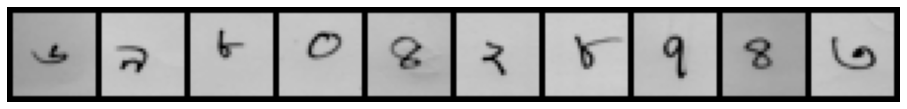

In [14]:
for images, labels in small_test_loader:
    print('images.shape:', images.shape)
    print(labels)

    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=10).permute((1, 2, 0)))
    break

In [20]:
images = images.view(-1, 28*28).to(device)

# Forward pass only to get logits/output
outputs = model(images)

# Get predictions from the maximum value
_, predicted = torch.max(outputs, 1)

print('Predicted labels', predicted.cpu().numpy())
print('Actual labels', labels)

Predicted labels [6 8 8 0 4 2 0 7 4 7]
Actual labels tensor([6, 9, 8, 0, 4, 2, 8, 7, 4, 3])


In [24]:
(predicted.cpu() == labels.cpu()).sum().item()

7